# Active Subspaces Tutorial

In this tutorial, we'll show you how to utilize active subspaces for dimension reduction with the [Python Active-Subspaces Utility Library](https://github.com/paulcon/active_subspaces). We'll demonstrate how to construct active subspaces with various components available and how to use the subspace to construct and use a response surface.

We examine the following circumstances in constructing subspaces:
1. You have only an interface to the function returning the quantity of interest, $f$.
2. You have access to the function $f$ and its gradient with respect to normalized inputs, $\nabla f$.

The function we use for demonstration is (as seen on [http://www.sfu.ca/~ssurjano/wingweight.html](http://www.sfu.ca/~ssurjano/wingweight.html)):

$$
f = 0.036\ S_w^{0.758}W_{fw}^{0.0035}\left(\frac{A}{\cos^2(\Lambda)}\right)^{0.6}q^{0.006}\lambda^{0.04}\left(\frac{100t_c}{\cos(\Lambda)}\right)^{-0.3}(N_zW_{dg})^{0.49}+S_wW_p,
$$

and its inputs (and distributions) are summarized below.

Variable|Symbol|Distribution (U(min, max))
:-----|:-----:|:-----
wing area|$S_w$|U(150, 200)
weight of fuel in the wing|$W_{fw}$|U(220, 300)
aspect ratio|$A$|U(6, 10)
quarter-chord sweep|$\Lambda$|U(-10, 10)
dynamic pressure at cruise|$q$|U(16, 45)
taper ratio|$\lambda$|U(0.5, 1)
aerofoil thickness to chord ratio|$t_c$|U(0.08, 0.18)
ultimate load factor|$N_z$|U(2.5, 6)
flight design gross weight|$W_{dg}$|U(1700, 2500)
paint weight|$W_p$|U(0.025, 0.08)

The first scenario we describe is when you have access to the function, $f$, but not its gradient (the file 'wing_functions.py' contains $f$ as defined above and its analytical gradient (wing and wing_grad, respectively), but for demonstration we initially pretend we don't have gradients). In this scenario, you have 3 options: use a global linear model to approximate gradients, use a global quadratic model to approximate gradients, or use local linear models to approximate gradients. We demonstrate each in turn.

In [1]:
%matplotlib inline
import active_subspaces as ac
import numpy as np
import matplotlib.pyplot as plt
from wing_functions import *

We first draw a set of inputs from the parameter space according to the distributions in the table above and compute the function's value at each of these points.

In [2]:
M = 1000 #This is the number of data points to use

#Sample the input space according to the distributions in the table above
Sw = np.random.uniform(150, 200, (M, 1))
Wfw = np.random.uniform(220, 300, (M, 1))
A = np.random.uniform(6, 10, (M, 1))
L = np.random.uniform(-10, 10, (M, 1))
q = np.random.uniform(16, 45, (M, 1))
l = np.random.uniform(.5, 1, (M, 1))
tc = np.random.uniform(.08, .18, (M, 1))
Nz = np.random.uniform(2.5, 6, (M, 1))
Wdg = np.random.uniform(1700, 2500, (M, 1))
Wp = np.random.uniform(.025, .08, (M, 1))

#The input matrix
x = np.hstack((Sw, Wfw, A, L, q, l, tc, Nz, Wdg, Wp))

#The function's output
f = wing(x)

#Upper and lower limits for inputs
ub = np.array([150, 220, 6, -10, 16, .5, .08, 2.5, 1700, .025]).reshape((1, 10))
lb = np.array([200, 300, 10, 10, 45, 1, .18, 6, 2500, .08]).reshape((1, 10))

#We normalize the inputs to the interval [-1, 1]: 
XX = 2.*(x - lb)/(ub - lb) - 1.0

The following cell instantiates a subspace object and computes the active subspace by fitting a global linear model (this is indicated by the 'sstype='OLS'' flag). The 'nboot=100' flag says to use 100 bootstrap replicates to estimate variability in eigenvalue and subspace error estimates.

In [3]:
#Instantiate a subspace object
ss = ac.subspaces.Subspaces()

#Compute the subspace with a global linear model (sstype='OLS') and 100 bootstrap replicates
ss.compute(X=XX, f=f, nboot=100, sstype='OLS')

n should be an integer. Performing conversion.


We plot estimated eigenvalues, subspace errors, and a sufficient summary plot (a plot of the active variable vs data values).

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


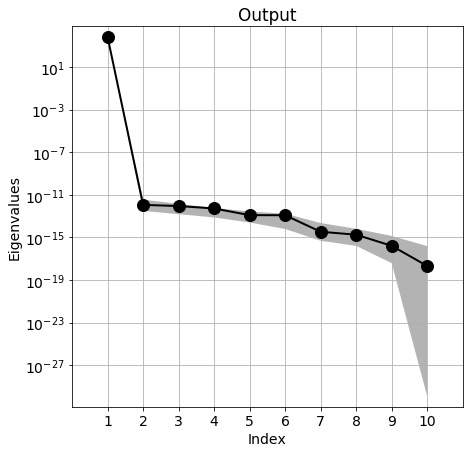

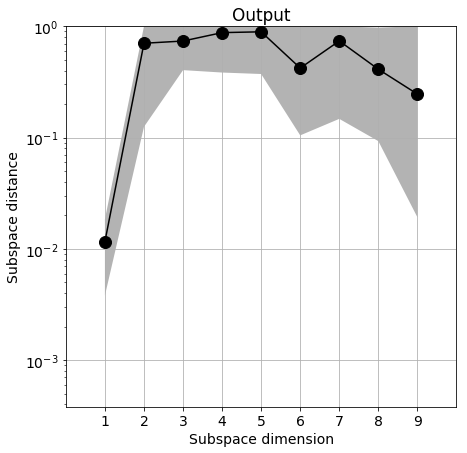

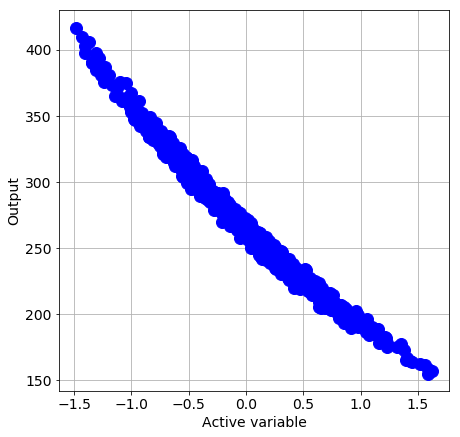

In [4]:
#This plots the eigenvalues (ss.eigenvals) with bootstrap ranges (ss.e_br)
ac.utils.plotters.eigenvalues(ss.eigenvals, ss.e_br)

#This plots subspace errors with bootstrap ranges (all contained in ss.sub_br)
ac.utils.plotters.subspace_errors(ss.sub_br)

#This makes sufficient summary plots with the active variables (XX.dot(ss.W1)) and output (f)
ac.utils.plotters.sufficient_summary(XX.dot(ss.W1), f)

We now make the same plots with a global quadratic model (sstype='QPHD').

n should be an integer. Performing conversion.


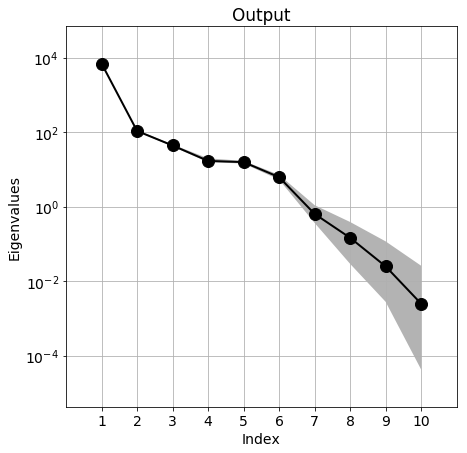

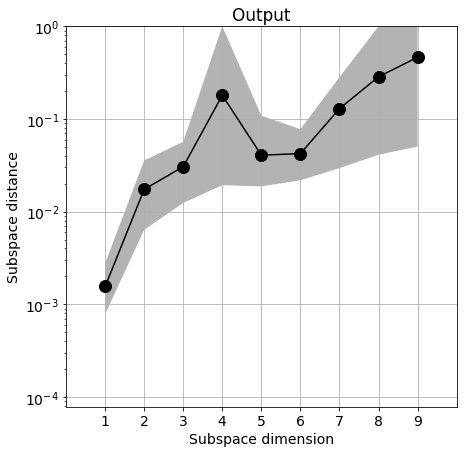

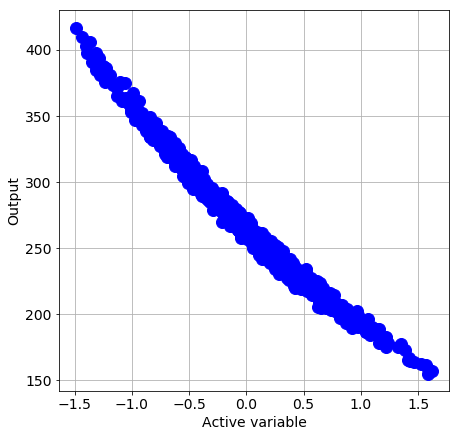

In [5]:
ss.compute(X=XX, f=f, nboot=100, sstype='QPHD')
ac.utils.plotters.eigenvalues(ss.eigenvals, ss.e_br)
ac.utils.plotters.subspace_errors(ss.sub_br)
ac.utils.plotters.sufficient_summary(XX.dot(ss.W1), f)

We now use local linear models to approximate gradients and make the same plots as above.

n should be an integer. Performing conversion.


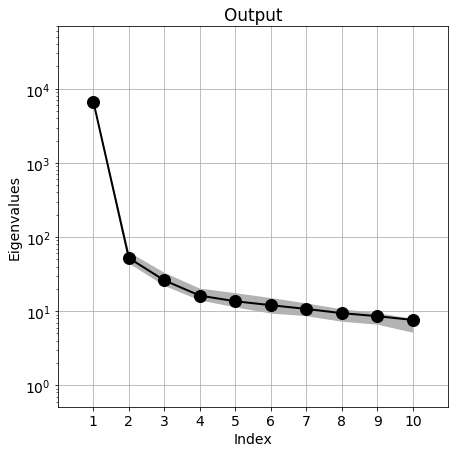

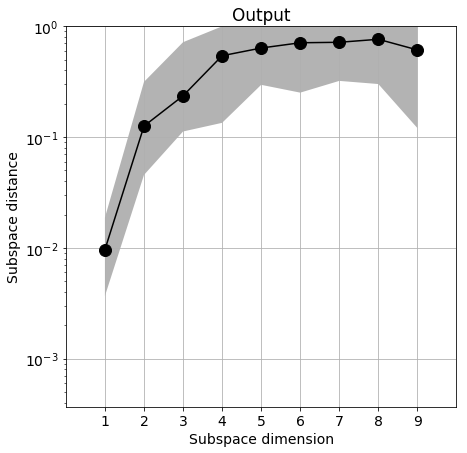

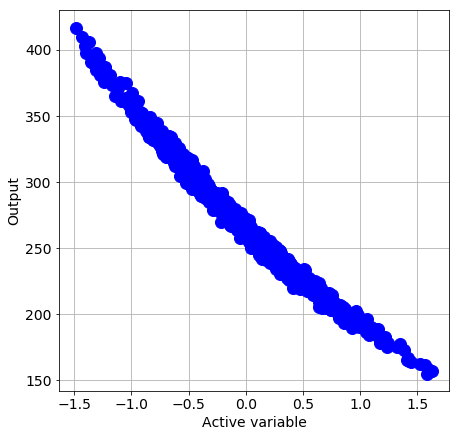

In [6]:
df = ac.gradients.local_linear_gradients(XX, f) #Estimated gradients using local linear models

ss.compute(df=df, nboot=100)
ac.utils.plotters.eigenvalues(ss.eigenvals, ss.e_br)
ac.utils.plotters.subspace_errors(ss.sub_br)
ac.utils.plotters.sufficient_summary(XX.dot(ss.W1), f)

We see tight trends in the summary plots in each case, which look very similar between the 3 approaches to approximating gradients. Because these trends look so similar between the approaches, it would likely not make much difference which one is used for constructing a response surface for this particular application, though the global linear model does not allow for higher-dimensional subspaces, so you would need to use a global quadratic model or local linear models if you needed a higher-dimensional space. The consistency between these approaches is not guaranteed; you should explore each for your application and decide which fits your needs the best.

We now demonstrate the construction of a subspace with direct access to gradients (computed analytically (our case) or using finite differences or adjoint methods). Since active subspaces use normalized input parameters, the gradients must be scaled according to the chain rule; if $x^*$ represents the normalized inputs, then $\frac{\partial f}{\partial x^*} = \frac{\partial f}{\partial x}\frac{\partial x}{\partial x^*}$, and $x^* = 2\frac{x-l}{u-l}-1\Rightarrow x = l + \frac{u-l}{2}(x^* + 1)\Rightarrow \frac{\partial x}{\partial x^*} = \frac{u-l}{2}$, where $u$ and $l$ are the upper and lower bounds on the input.

n should be an integer. Performing conversion.


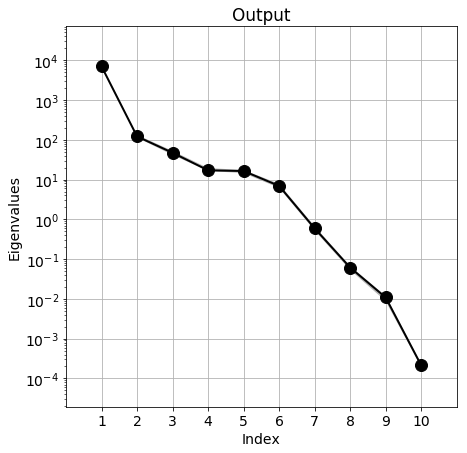

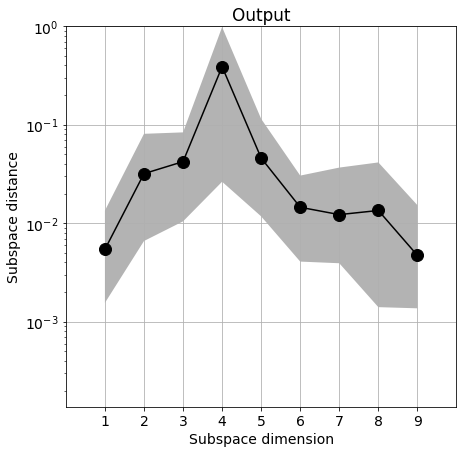

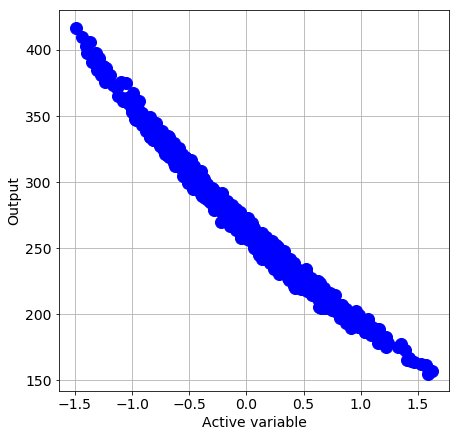

In [7]:
df = wing_grad(x) #Analytically computed gradients

#Chain Rule
df *= (ub - lb)/2.
#Additional chain rule factor for going from degrees to radians
df[:,3] *= np.pi/180.

ss.compute(df=df, nboot=100)
ac.utils.plotters.eigenvalues(ss.eigenvals, ss.e_br)
ac.utils.plotters.subspace_errors(ss.sub_br)
ac.utils.plotters.sufficient_summary(XX.dot(ss.W1), f)

The summary plot looks very similar to the plots created by approximating gradients with input/output pairs. This is also not guaranteed; having exact gradients will often result in tighter trends in summary plots because you don't have the additional layer of error from approximating gradients.

We'll now construct and use a response surface: a function of the active variable(s) that approximates model output. These are fit with least-squares and can be used to integrate, average, or optimize the function $f$. In the case presented here, we see some curvature in the summary plots, so we use a quadratic surface; your summary plots may indicate better fit with linear, cubic, or other models. The code allows for both polynomial and radial-basis surfaces, both of which have constructors that accept the order of the surface (1 $\rightarrow$ linear, 2 $\rightarrow$ quadratic, etc.). Each class has an Rsqr ($R^2$) attribute that measures goodness-of-fit and a 'predict' function that takes active variable values and a flag telling whether to compute the response surface's gradient, and returns the predicted value and gradient (the gradient is None if the flag is False or absent).

The R^2 value of the response surface is 0.9916


Text(0,0.5,'Output')

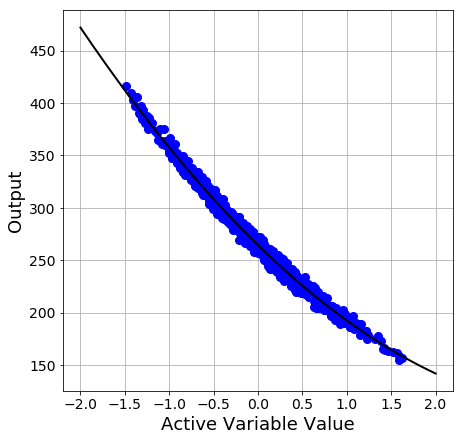

In [8]:
#quadratic polynomial approximation
RS = ac.utils.response_surfaces.PolynomialApproximation(2)

#Train the surface with active variable values (y = XX.dot(ss.W1)) and function values (f)
y = XX.dot(ss.W1)
RS.train(y, f)
print('The R^2 value of the response surface is {:.4f}'.format(RS.Rsqr))

#Plot the data and response surface prediction
plt.figure(figsize=(7, 7))
y0 = np.linspace(-2, 2, 200)
plt.plot(y, f, 'bo', y0, RS.predict(y0[:,None])[0], 'k-', linewidth=2, markersize=8)
plt.grid(True)
plt.xlabel('Active Variable Value', fontsize=18)
plt.ylabel('Output', fontsize=18)

We can see from the $R^2$ value and the graph that the response surface is a good fit. We'll demonsrate how to use the response surface to estimate the average and minimum of the quantity of interest. We must first construct an active variable domain (requiring a computed subspace object) and an active variable map (requiring a domain object).

In [9]:
avdom = ac.domains.BoundedActiveVariableDomain(ss)
avmap = ac.domains.BoundedActiveVariableMap(avdom)

Now we show how to average the quantity of interest against the joint distribution of input parameters using the response surface, and compare this estimate to a Monte Carlo estimate using the full input space.

In [10]:
#import time for runtime comparison
import time

tb_as = time.time()

#Approximate the average of the quantity of interest by integrating the response surface
int_I = ac.integrals.av_integrate(lambda x: RS.predict(x)[0], avmap, 1000)
print('The estimated average using the response surface is {:.2f}'.format(int_I))

te_as = time.time()

tb_mc = time.time()

#Approximate the average using simple Monte Carlo with M replicates
M = int(1e5)
X = np.random.uniform(-1, 1, (M, 10))
X = lb + (ub - lb)/2.*(X + 1)
MC_f = wing(X)
MC_I = MC_f.sum()/M
MCSE = MC_f.std(ddof=1)/np.sqrt(M)
print('The estimated average using standard Monte Carlo is {:.2f} with 95% CI ({:.2f}, {:.2f})'\
    .format(MC_I, MC_I - 1.96*MCSE, MC_I + 1.96*MCSE))
    
te_mc = time.time()

print('Active subspaces took {:.1f} seconds and MCMC took {:.1f} seconds'\
    .format(te_as - tb_as, te_mc - tb_mc))

The estimated average using the response surface is 267.38
The estimated average using standard Monte Carlo is 268.33 with 95% CI (268.04, 268.63)
Active subspaces took 0.1 seconds and MCMC took 0.2 seconds


We see very close answers between these methods, which we would expect based on the good fit of the response surface. The Monte Carlo method takes significantly longer to run despite our model being a fairly simple algebraic equation; for models that take many minutes or hours to run, accurate Monte Carlo (or other traditional integration methods) may be infeasible. We now demonstrate the use of the response surface in minimization and compare the response surface result with the results of a scipy optimizer on the full input space.

In [11]:
#Minimize using the response surface
ystar, fstar = ac.optimizers.av_minimize(lambda x: RS.predict(x.reshape(1,1))[0], avdom)
print('The response surface optimization results are\n: ystar = {:.4f}, fstar = {:.4f}\n'.\
    format(ystar[0,0], fstar[0,0]))

#Minimize using scipy
import scipy.optimize as opt
#wing_n takes normalized inputs while wing takes unnormalized inputs
wing_n = lambda x: wing(lb + (ub - lb)/2.*(x + 1))
scipy_res = opt.minimize(wing_n, np.zeros(10), bounds=([(-1.0, 1.0) for _ in range(10)] ))
print('The scipy optimization results are:')
print('xstar = {}, fstar = {:.4f}'.format(scipy_res['x'], scipy_res['fun'][0,0]))
print('xstar*W1 = {:.4f}'.format(scipy_res['x'].reshape((1, 10)).dot(ss.W1)[0,0]))

The response surface optimization results are
: ystar = 2.2585, fstar = 132.2726

The scipy optimization results are:
xstar = [ 1.  1.  1.  0.  1.  1. -1.  1.  1.  1.], fstar = 123.2537
xstar*W1 = 2.2567


We can see the estimated minima are fairly close and the estimated active-variable minimizers are almost the same. Again, the algebraic nature of our quantity of interest makes traditional methods feasible; if it were more complex, e.g. the numerical approximation of a PDE that takes hours to compute, the scipy optimizers might become infeasible.